## Description:

- Calculates sun's position on panoramic
- Determines visible sky
- Calculates sun glare

In [1]:
import matplotlib.pyplot as plt
from pysolar.solar import get_altitude, get_azimuth
from datetime import datetime, timezone
from PIL import Image
import math

def plot_dot_on_image(img_path, xc, yc, color='red', title="Sun's Incidence Point on Cylindrical GSV Panorama"):

    with Image.open(img_path) as img:
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.scatter(xc, yc, color=color, label="Sun's Incidence Point")
        plt.text(xc + 10, yc - 10, f"({int(xc)}, {int(yc)})", color='red', fontsize=12)
        plt.title(title)
        plt.show()

def get_image_width_height(img_path):
    with Image.open(img_path) as img:
        width, height = img.size
    return width, height

def get_sun_position_east(latitude: float, longitude: float, date: datetime):
    altitude = get_altitude(latitude, longitude, date)  # degrees
    azimuth = get_azimuth(latitude, longitude, date)  #  degrees

    # convert to be anticlockwise from east
    azimuth = 90 - azimuth
    if azimuth < 0:
        azimuth = azimuth + 360  

    return altitude, azimuth


def get_sun_position_on_panoramic_with_heading_date_slope(pan_img_path, lat, long, heading, date=datetime.now(timezone.utc), driveway_slope=0):
    driving_direction = heading
    
    altitude, azimuth = get_sun_position_east(lat, long, date)
    
    wc, hc = get_image_width_height(pan_img_path)
    cx = wc/2
    cy = hc/2

    rad_azimuth = math.radians(azimuth)
    rad_altitude = math.radians(altitude)
    rad_driving_direction = math.radians(driving_direction)
    rad_driveway_slope = math.radians(driveway_slope)

    sun_x = (((rad_driving_direction - rad_azimuth) / (2 * math.pi)) * wc) + cx
    sun_y = cy - (((rad_altitude - rad_driveway_slope) / (math.pi/2)) * hc)
    
    return sun_x, sun_y

### Image Processing:

In [2]:
import torch
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import matplotlib.patches as mpatches
import numpy as np

def plot_image(image, title="None"):
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")  # Hide axes for cleaner visualization
    plt.show()

def plot_dot_on_image_obj(img, x, y, title="No Title" , color='red' ):
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.scatter(x, y, color=color, label="Sun's Incidence Point" )
    plt.text(x + 10, y - 10, f"({int(x)}, {int(y)})", color='red', fontsize=12)
    plt.title(title)
    plt.show()

def convert_image_to_segmentation_map(image_path):
    feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

    # url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    url = image_path
    image = Image.open(url)
    # image = Image.open(requests.get(url, stream=True).raw)

    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

    # Step 1: Convert logits to class predictions
    predicted_class = torch.argmax(logits, dim=1)  # shape (batch_size, height/4, width/4)

    # Step 2: Upsample to match input image size
    predicted_class = torch.nn.functional.interpolate(
        predicted_class.unsqueeze(1).float(),  # Add channel dimension
        size=image.size[::-1],  # Match input image dimensions (height, width)
        mode="nearest"
    ).squeeze(1).to(torch.int32)  # Remove channel dimension

    # Step 3: Visualize
    # Convert to numpy array for visualization
    segmentation_map = predicted_class[0].cpu().numpy()

    # Create a color map
    num_classes = logits.shape[1]
    cmap = plt.get_cmap('jet', num_classes)  # Choose a colormap with sufficient colors

    # Plot the original image and segmentation map
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Segmentation map
    ax[1].imshow(segmentation_map, cmap=cmap, vmin=0, vmax=num_classes - 1)
    ax[1].set_title("Segmentation Map")
    ax[1].axis("off")

    legend_patches = [
        mpatches.Patch(color=cmap(i / num_classes), label=f'Class {i}') for i in range(num_classes)
    ]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")


    plt.tight_layout()
    plt.show()

    # save the image
    plt.imsave("segmented_image.jpg", segmentation_map, cmap=cmap, vmin=0, vmax=num_classes - 1)

    return segmentation_map


# returns False is the x,y are in the sky class 
def check_if_sun_is_blocked(segmentation_map, x, y, sky_class=10):
    # create mask of sky
    sky_masks = (segmentation_map == 10).astype(np.uint8) * 255
    # plot_image(sky_masks, title="Sky Mask")
    plot_dot_on_image_obj(sky_masks, x, y, title="Sky Mask", color='red')
    # check if x,y is in the sky mask

    x = int(x)
    y = int(y)

    print(sky_masks[y,x])

    # Sky is 255, other is 0
    return sky_masks[y,x] == 0


c:\Users\Jared\OneDrive\Desktop\UrbanRep\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


|173.5208895124993-174.4101|=0.8892104875006908
Sun glare potential


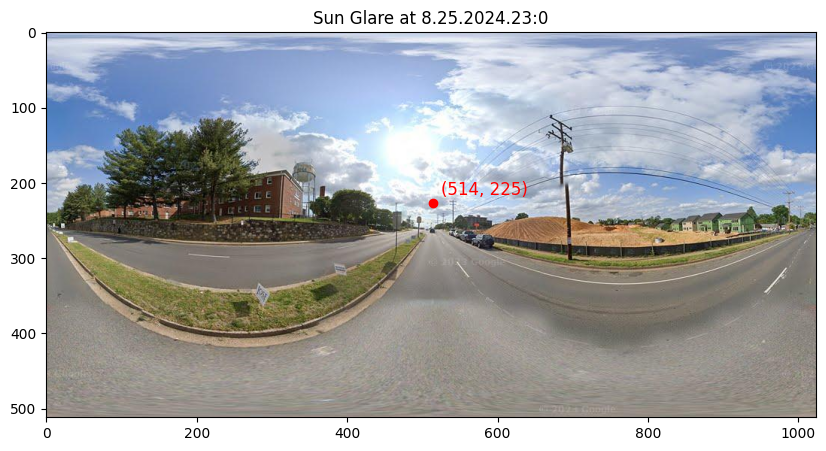

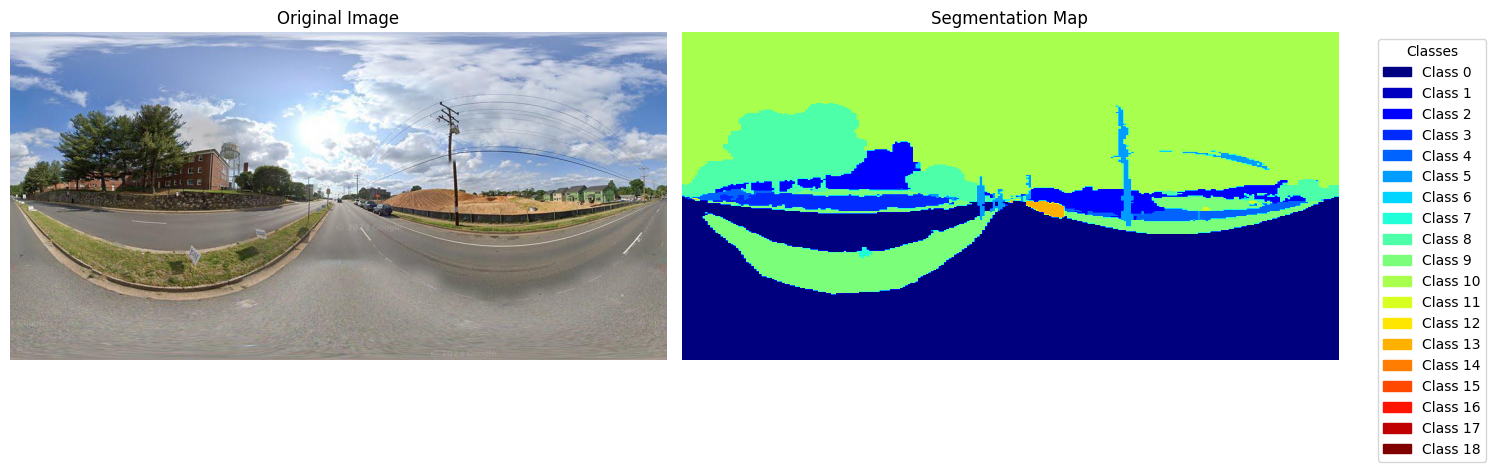

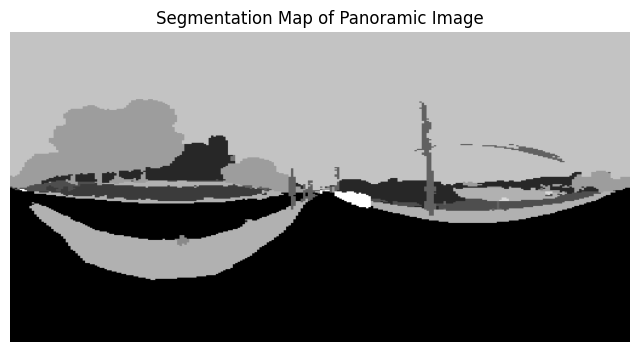

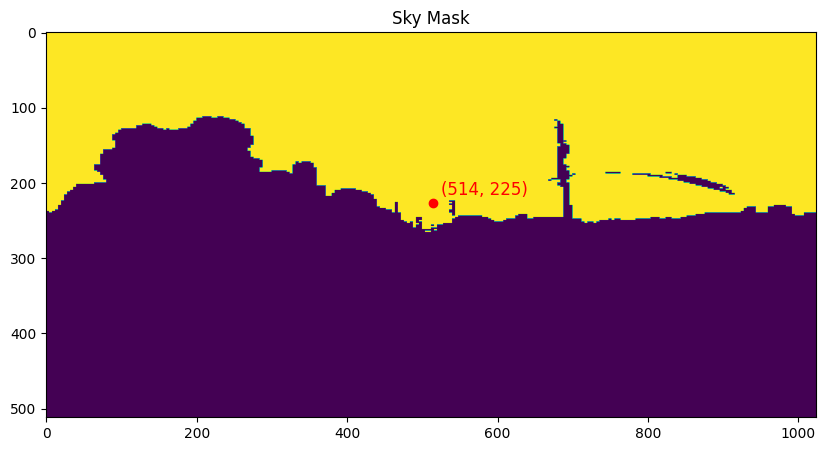

255
Sun glare not blocked


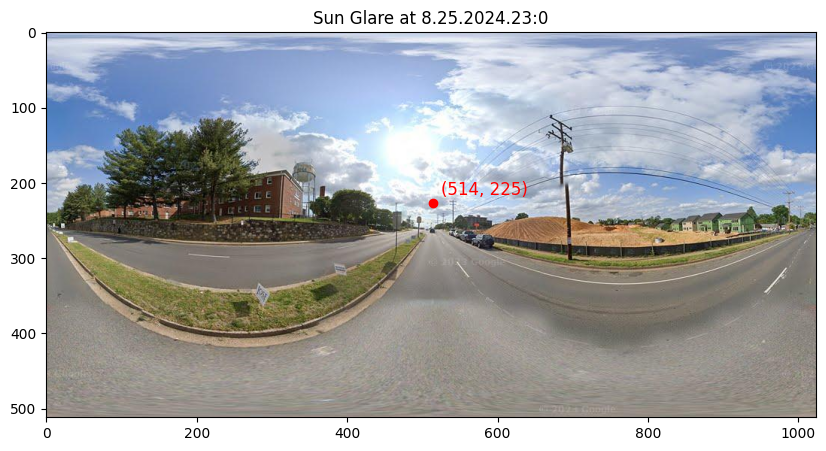

In [6]:
from datetime import datetime, timedelta, timezone
import math

def determine_sun_position(panoramic_path, lat, long, date, heading, tilt):

    # calculate the sun position for the given time
    xc, yc = get_sun_position_on_panoramic_with_heading_date_slope(panoramic_path, lat, long, heading, date=date, driveway_slope=tilt)

    wc, hc = get_image_width_height(panoramic_path)
    
    # wrap the x-coordinate around the panoramic width
    xc = xc % wc

    #plot it 
    # plot_dot_on_image(panoramic_path, xc, yc)

    return xc, yc


def main():
    # note the date is in UTC
    date = datetime(2024, 8, 25, 23, 0, 0, tzinfo=timezone.utc)
    
    # Note: we get this from api metadata calls (but just hardcoded for now)
    lat, long = (38.8733054,-77.1459455)
    heading = 174.4101# Note: anticlockwise from east 
    tilt = 3.2755400000000066

    panoramic_file = "data\panoramic_imgs\CD--LdA9GqIzH05haIJH3w.jpg"
    
    # get sun position on panoramic image
    sun_x, sun_y = determine_sun_position(panoramic_file, lat, long, date, heading, tilt)

    altitude, azimuth = get_sun_position_east(lat, long, date)
    actual_heading = heading# (dont forget % 360) heading of panorama may be different from actual heading of the driveway (ex: backroads with 1 lane but 2 directions)
   
    # check if angle would cause sun glare (h_glare and v_glare are lower than 25 deg.)
    print(f"|{azimuth}-{actual_heading}|={abs(azimuth - actual_heading)}")
    h_glare = abs(azimuth - actual_heading)
    v_glare = abs(altitude - tilt)
    
    if (h_glare < 25) and (v_glare < 25):
        print("Sun glare potential")
        plot_dot_on_image(panoramic_file, sun_x, sun_y, color='red', title=f"Sun Glare at {date.month}.{date.day}.{date.year}.{date.hour}:{date.minute}")
        
        # check if something blocks the sun
        # TODO remove trees (if it is a winter month...)

        #get segmentation map of the panoramic image without trees
        segmentation_map = convert_image_to_segmentation_map(panoramic_file)
        plot_image(segmentation_map, title="Segmentation Map of Panoramic Image")
    
        # check if the sun touches the sky
        has_sun_glare = check_if_sun_is_blocked(segmentation_map, sun_x, sun_y)
        
        if has_sun_glare:
            print("Sun glare blocked by an object")
            plot_dot_on_image(panoramic_file, sun_x, sun_y, color='yellow', title=f"Sun Glare at {date.month}.{date.day}.{date.year}.{date.hour}:{date.minute}")

        else:
            print("Sun glare not blocked")    
            plot_dot_on_image(panoramic_file, sun_x, sun_y, color='red', title=f"Sun Glare at {date.month}.{date.day}.{date.year}.{date.hour}:{date.minute}")


    else:
        # no chance of sun glare, so no need to check if something blocks it
        print("No Sun glare detected")
        plot_dot_on_image(panoramic_file, sun_x, sun_y, color='green',title=f"Sun Glare at {date.month}.{date.day}.{date.year}.{date.hour}:{date.minute}")

main()  